In [0]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [0]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# 9.9 语义分割和数据集

在前几节讨论的目标检测问题中，我们一直使用方形边界框来标注和预测图像中的目标。本节将探讨语义分割（semantic segmentation）问题，它关注如何将图像分割成属于不同语义类别的区域。值得一提的是，这些语义区域的标注和预测都是像素级的。图9.10展示了语义分割中图像有关狗、猫和背景的标签。可以看到，与目标检测相比，语义分割标注的像素级的边框显然更加精细。

![alt text](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter09/9.9_segmentation.svg)

图9.10 语义分割中图像有关狗、猫和背景的标签

## 9.9.1 图像分割和实例分割

计算机视觉领域还有2个与语义分割相似的重要问题，即图像分割（image segmentation）和实例分割（instance segmentation）。我们在这里将它们与语义分割简单区分一下。

* 图像分割将图像分割成若干组成区域。这类问题的方法通常利用图像中像素之间的相关性。它在训练时不需要有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义。以图9.10的图像为输入，图像分割可能将狗分割成两个区域：一个覆盖以黑色为主的嘴巴和眼睛，而另一个覆盖以黄色为主的其余部分身体。
* 实例分割又叫同时检测并分割（simultaneous detection and segmentation）。它研究如何识别图像中各个目标实例的像素级区域。与语义分割有所不同，实例分割不仅需要区分语义，还要区分不同的目标实例。如果图像中有两只狗，实例分割需要区分像素属于这两只狗中的哪一只。

## 9.9.2 Pascal VOC2012语义分割数据集

语义分割的一个重要数据集叫作Pascal VOC2012 [1]。为了更好地了解这个数据集，我们先导入实验所需的包或模块。

In [0]:
import time
from tqdm import tqdm
import sys
sys.path.append("..")

我们先下载这个数据集的压缩包（[下载地址](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar)）。压缩包大小是2 GB左右，下载需要一定时间。下载后解压得到VOCdevkit/VOC2012文件夹，然后将其放置在data文件夹下。

In [0]:
# 下载并解压文件到data目录
import requests
import tarfile

r = requests.get("http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar")
with open("data/VOCtrainval_11-May-2012.tar", 'wb') as f:
    f.write(r.content)

def extract(tar_path, target_path):
    try:
        t = tarfile.open(tar_path)
        t.extractall(path = target_path)
        return True
    except:
        return False

extract("data/VOCtrainval_11-May-2012.tar", "data/")

True

解压后包含：

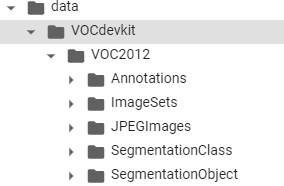

```
Annotations        JPEGImages         SegmentationObject
ImageSets          SegmentationClass
```



进入data/VOCdevkit/VOC2012路径后，我们可以获取数据集的不同组成部分。其中ImageSets/Segmentation路径包含了指定训练和测试样本的文本文件，而JPEGImages和SegmentationClass路径下分别包含了样本的输入图像和标签。这里的标签也是图像格式，其尺寸和它所标注的输入图像的尺寸相同。标签中颜色相同的像素属于同一个语义类别。下面定义read_voc_images函数将输入图像和标签读进内存。

train.txt文件内容如下：



```
2007_000032
2007_000039
2007_000063
2007_000068
2007_000121
2007_000170
...
```



In [0]:
def read_voc_images(root="data/VOCdevkit/VOC2012", 
            is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in tqdm(enumerate(images)):
        feature_tmp = tf.io.read_file('%s/JPEGImages/%s.jpg' % (root, fname))
        features[i] = tf.image.decode_jpeg(feature_tmp)
        label_tmp = tf.io.read_file('%s/SegmentationClass/%s.png' % (root, fname))
        labels[i] = tf.image.decode_png(label_tmp)
    return features, labels #shape=(h, w, c)

In [0]:
from PIL import Image
root="data/VOCdevkit/VOC2012"
fname="2007_000032"

feature = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert("RGB")
label = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert("RGB")
feature.size    #(w, h)

(500, 281)

(281, 500, 3)
(281, 500, 3)


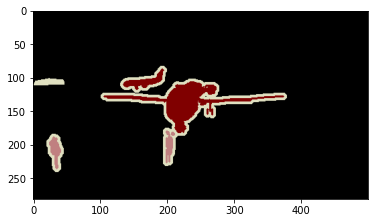

In [0]:
feature = tf.io.read_file('%s/JPEGImages/%s.jpg' % (root, fname))
feature = tf.image.decode_jpeg(feature)
print(feature.shape)   #(h, w, c)
label = tf.io.read_file('%s/SegmentationClass/%s.png' % (root, fname))
label = tf.image.decode_png(label)
print(label.shape)
plt.imshow(label)   #(h, w, c)

In [0]:
voc_dir = "data/VOCdevkit/VOC2012"
train_features, train_labels = read_voc_images(voc_dir, max_num=100)

100it [00:00, 212.86it/s]


我们画出前5张输入图像和它们的标签。在标签图像中，白色和黑色分别代表边框和背景，而其他不同的颜色则对应不同的类别。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f482db089e8>,
      dtype=object)

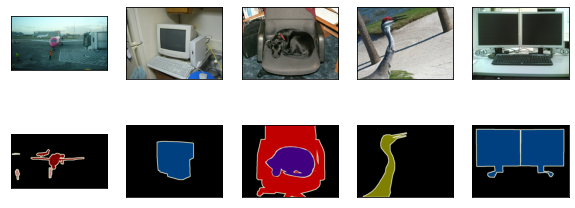

In [0]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
show_images(imgs, 2, n)

接下来，我们列出标签中每个RGB颜色的值及其标注的类别。

In [0]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

有了上面定义的两个常量以后，我们可以很容易地查找标签中每个像素的类别索引。

In [0]:
colormap2label = np.zeros(256 ** 3, dtype=np.uint8)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
colormap2label = tf.convert_to_tensor(colormap2label)

# 本函数已保存在d2lzh_pytorch中方便以后使用(没)
def voc_label_indices(colormap, colormap2label):
    """
    convert colormap (tf image) to colormap2label (uint8 tensor).
    """
    colormap = tf.cast(colormap, dtype=tf.int32)
    idx = tf.add(tf.multiply(colormap[:, :, 0], 256), colormap[:, :, 1])
    idx = tf.add(tf.multiply(idx, 256), colormap[:, :, 2])
    idx = tf.add(idx, colormap[:, :, 2])

    # print(tf.gather_nd(colormap2label, tf.expand_dims(idx, -1)))
    return tf.gather_nd(colormap2label, tf.expand_dims(idx, -1))

例如，第一张样本图像中飞机头部区域的类别索引为1，而背景全是0。

In [0]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(<tf.Tensor: shape=(10, 10), dtype=uint8, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=uint8)>, 'aeroplane')

## 9.9.2.1 预处理数据

在之前的章节中，我们通过缩放图像使其符合模型的输入形状。然而在语义分割里，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。这样的映射难以做到精确，尤其在不同语义的分割区域。为了避免这个问题，我们将图像裁剪成固定尺寸而不是缩放。具体来说，我们使用图像增广里的随机裁剪，并对输入图像和标签裁剪相同区域。

In [0]:
def voc_rand_crop(feature, label, height, width):
    """
    Random crop feature (tf image) and label (tf image).
    先将channel合并，剪裁之后再分开
    """
    combined = tf.concat([feature, label], axis=2)
    last_label_dim = tf.shape(label)[-1]
    last_feature_dim = tf.shape(feature)[-1]
    combined_crop = tf.image.random_crop(combined,
                        size=tf.concat([(height, width), [last_label_dim + last_feature_dim]],axis=0))
    return combined_crop[:, :, :last_feature_dim], combined_crop[:, :, last_feature_dim:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f482db49438>,
      dtype=object)

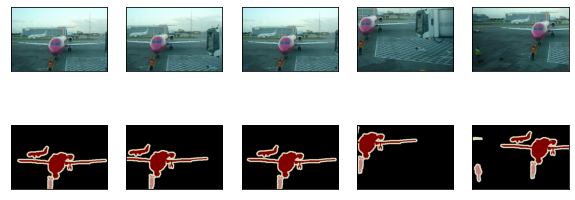

In [0]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

show_images(imgs[::2] + imgs[1::2], 2, n)

## 9.9.2.2 自定义语义分割数据集类

我们通过自定义了一个获取语义分割数据集函数getVOCSegDataset。由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本需要通过自定义的filter函数所移除。此外，我们还对输入图像的RGB三个通道的值分别做标准化。

In [0]:
def getVOCSegDataset(is_train, crop_size, voc_dir, colormap2label, max_num=None):
    """
    crop_size: (h, w)
    """
    features, labels = read_voc_images(root=voc_dir, 
                        is_train=is_train,
                        max_num=max_num)
    def _filter(imgs, crop_size):
        return [img for img in imgs if (
            img.shape[0] >= crop_size[0] and
            img.shape[1] >= crop_size[1])]
    
    def _crop(features, labels):
        features_crop = []
        labels_crop = []
        for feature, label in zip(features, labels):
            feature, label = voc_rand_crop(feature, label, 
                            height=crop_size[0],
                            width=crop_size[1])
            features_crop.append(feature)
            labels_crop.append(label)
        return features_crop, labels_crop
    
    def _normalize(feature, label):
        rgb_mean = np.array([0.485, 0.456, 0.406])
        rgb_std = np.array([0.229, 0.224, 0.225])
        
        label = voc_label_indices(label, colormap2label)
        feature = tf.cast(feature, tf.float32)
        feature = tf.divide(feature, 255.)
        # feature = tf.divide(tf.subtract(feature, rgb_mean), rgb_std)
        return feature, label

    features = _filter(features, crop_size)
    labels = _filter(labels, crop_size)
    features, labels = _crop(features, labels)

    print('read ' + str(len(features)) + ' valid examples')
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.map(_normalize)
    return dataset

## 9.9.2.3 读取数据集

我们通过自定义的getVOCSegDataset来分别创建训练集和测试集的实例。假设我们指定随机裁剪的输出图像的形状为320×400。下面我们可以查看训练集和测试集所保留的样本个数。

In [0]:
crop_size = (320, 400)
max_num = 100

voc_train = getVOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = getVOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

100it [00:00, 276.14it/s]
29it [00:00, 281.40it/s]

read 77 valid examples


100it [00:00, 280.96it/s]


read 82 valid examples


设批量大小为64，分别定义训练集和测试集的迭代器。

In [0]:
batch_size = 64
voc_train = voc_train.batch(batch_size)
voc_test = voc_test.batch(batch_size)

In [0]:
for x, y in iter(voc_train):
    print(x.dtype, x.shape)
    print(y.dtype, y.shape)
    break

<dtype: 'float32'> (64, 320, 400, 3)
<dtype: 'uint8'> (64, 320, 400)


## 小结

* 语义分割关注如何将图像分割成属于不同语义类别的区域。
* 语义分割的一个重要数据集叫作Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，所以将图像随机裁剪成固定尺寸而不是缩放。